In [1]:
import datetime

import pandas as pd
import spacy
import re
import string
import numpy as np

from spacy.tokens import Token
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import seaborn as sns 
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import cross_val_score , GridSearchCV,train_test_split
from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc

%matplotlib inline
np.random.seed(500)

In [2]:
df = pd.read_csv("..//data//Womens Clothing E-Commerce Reviews Sentiment v2.csv")

In [3]:
def renames(feature, values):
    Dict_cols={}
    for value in values:
        Dict_cols[value]=feature+value
    return Dict_cols

In [4]:
## Encoding a categorical column
column_name='Division Name'
dummies= pd.get_dummies(df[column_name])
df=pd.concat([df,dummies], axis=1,ignore_index=False)
Division_columns=renames(column_name+'_',dummies.columns.tolist())
df=df.rename(index=str, columns=Division_columns)

column_name='Department Name'
dummies= pd.get_dummies(df[column_name])
df=pd.concat([df,dummies], axis=1,ignore_index=False)
Department_columns=renames(column_name+'_',dummies.columns.tolist())
df=df.rename(index=str, columns=Department_columns)

column_name='Class Name'
dummies= pd.get_dummies(df[column_name])
df=pd.concat([df,dummies], axis=1,ignore_index=False)
Class_columns=renames(column_name+'_',dummies.columns.tolist())
df=df.rename(index=str, columns=Class_columns)

In [5]:
df.columns

Index(['Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name', 'processed_Review_text', 'PA_Polarity',
       'PA_Subjectivity', 'Division Name_General',
       'Division Name_General Petite', 'Division Name_Initmates',
       'Department Name_Bottoms', 'Department Name_Dresses',
       'Department Name_Intimate', 'Department Name_Jackets',
       'Department Name_Tops', 'Department Name_Trend', 'Class Name_Blouses',
       'Class Name_Casual bottoms', 'Class Name_Chemises',
       'Class Name_Dresses', 'Class Name_Fine gauge', 'Class Name_Intimates',
       'Class Name_Jackets', 'Class Name_Jeans', 'Class Name_Knits',
       'Class Name_Layering', 'Class Name_Legwear', 'Class Name_Lounge',
       'Class Name_Outerwear', 'Class Name_Pants', 'Class Name_Shorts',
       'Class Name_Skirts', 'Class Name_Sleep', 'Class Name_Sweaters',
       'Class Name_Swim', 'Class Name_Trend'],


In [6]:
## Discarding a empty reviews & removing the other columns

df=df[((df.processed_Review_text.isna()==False) & (df.processed_Review_text.isnull()==False) & (df.processed_Review_text!=""))]

In [7]:
# TF IDF Conversion
vectorizer = TfidfVectorizer(ngram_range=(2, 2), max_features=15448)
review_vectors = vectorizer.fit_transform(df["processed_Review_text"])
features_df = pd.DataFrame(review_vectors.toarray(), columns = vectorizer.get_feature_names())
review_columns= vectorizer.get_feature_names()

In [8]:
# # # TF IDF Conversion
# vectorizer = TfidfVectorizer()
# review_vectors = vectorizer.fit_transform(df["processed_Review_text"])
# features_df = pd.DataFrame(review_vectors.toarray(), columns = vectorizer.get_feature_names())
# review_columns= vectorizer.get_feature_names()

In [9]:
features_df.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)
df=pd.concat([df,features_df], axis=1,ignore_index=False)

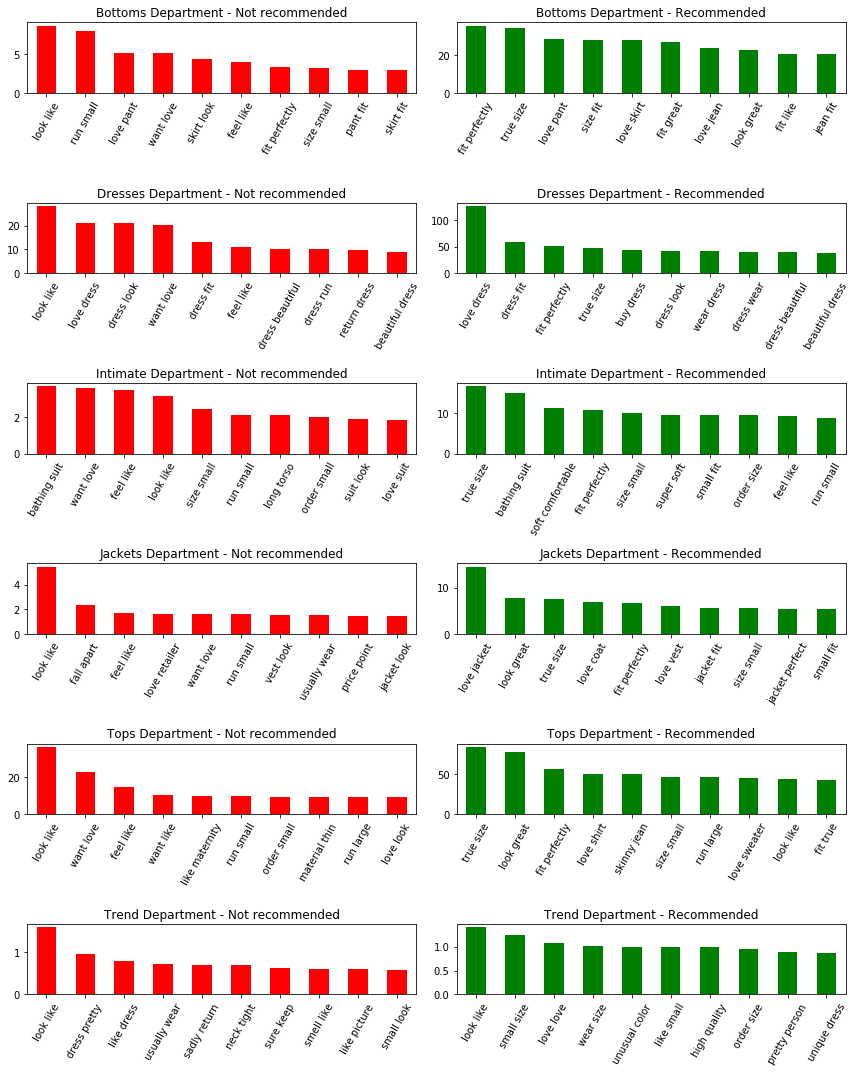

In [10]:
wordslist=df.columns.tolist()[42:]

plt.subplots(figsize=(12,15))  
i=1
for (d,r),bucket in df.groupby(['Department Name','Recommended IND']):
    
    plt.subplot(6,2,i)
    if r==0:
        bucket[wordslist].sum().sort_values(ascending=False).head(10).plot(kind='bar',color='red')
        plt.title(d+' Department - Not recommended')
    else:
        bucket[wordslist].sum().sort_values(ascending=False).head(10).plot(kind='bar',color='green')
        plt.title(d+' Department - Recommended')
    plt.xticks(rotation=60)
    
    i=i+1
    plt.tight_layout()

In [11]:
df=df.drop(columns=['Clothing ID','Title','Division Name', 'Department Name', 'Class Name','Positive Feedback Count','Review Text','processed_Review_text'])

In [12]:
InputFeature=df.columns.tolist()
OutputFeature='Recommended IND'
InputFeature.remove(OutputFeature)

In [13]:
## For Hyper parameter selection used Grid Search

def param_selection(model,param_grid,InputFeatureData,OutputFeatureData, nfolds=3):
#     print(str(datetime.datetime.now())+" : Starting Param selection")
    grid_search = GridSearchCV(model, param_grid, cv=nfolds,verbose =1)
    grid_search.fit(InputFeatureData,OutputFeatureData)
    print("Best Parmater for model : "+ str(grid_search.best_params_))
#     print(str(datetime.datetime.now())+" : Param selection is completed")
    return grid_search.best_estimator_

def Category_coefs(modelbest_estimator,columnslist, ImpFtrShow, label, subplotnbr, InputFeature=InputFeature):
        
    if type(modelbest_estimator).__name__=='LogisticRegression':
        if(subplotnbr>0):
            plt.subplot(2,2,subplotnbr);
        
        # Coeffiencents
        coefs=pd.DataFrame({'Featrures':InputFeature, 'Coeff':modelbest_estimator.coef_[0]})
        coefs=coefs[coefs['Featrures'].isin(columnslist)]
        if ImpFtrShow==0 or ImpFtrShow*2>len(coefs['Featrures']) :
            coefs=coefs.sort_values(by=['Coeff'],ascending=False)
            title= label+' Features of Coeff''s '
        else:
            ## Accounting both positive & negative important coefficients
            coefs=pd.concat([coefs.sort_values(by=['Coeff'],ascending=False).head(ImpFtrShow),coefs.sort_values(by=['Coeff'],ascending=False).tail(ImpFtrShow)])
            title='Top & Bottom '+str(ImpFtrShow*2)+' '+label+' Features of Coeff''s '
        plt.bar(coefs['Featrures'], coefs['Coeff']);
        plt.title(title)
        plt.xticks(rotation=70)
    
    elif type(modelbest_estimator).__name__=='MultinomialNB':
        
        # feature_log_prob_
        pred1=pd.DataFrame({'Featrures':InputFeature, 'prob':modelbest_estimator.feature_log_prob_[1]})
        pred0=pd.DataFrame({'Featrures':InputFeature, 'prob':modelbest_estimator.feature_log_prob_[0]})
        
        pred0=pred0[pred0['Featrures'].isin(columnslist)]
        pred1=pred1[pred1['Featrures'].isin(columnslist)]
        
        if ImpFtrShow==0 or ImpFtrShow*2>len(pred0['Featrures'])  :
            pred0=pred0.sort_values(by=['prob'],ascending=False)
            pred1=pred1.sort_values(by=['prob'],ascending=False)
            title= label+' Features of log probablity '
        else:
            pred0=pred0.sort_values(by=['prob'],ascending=False).head(ImpFtrShow)
            pred1=pred1.sort_values(by=['prob'],ascending=False).head(ImpFtrShow)
            title='Top '+str(ImpFtrShow)+' '+label+' Features of log probablity'
        
        if(subplotnbr==0):
            plt.subplot(1,2,1)
            plt.bar(pred0['Featrures'], pred0['prob'], color='red');
            plt.title(title+ ' for NonRec')
            plt.xticks(rotation=70)
            plt.subplot(1,2,2)
            plt.bar(pred1['Featrures'], pred1['prob'], color='green');
            plt.title(title+ ' for Rec')
            plt.xticks(rotation=70)
        else:
            plt.subplot(4,4,(subplotnbr*2)-1)
            plt.bar(pred0['Featrures'], pred0['prob'], color='red');
            plt.title(title)
            plt.xticks(rotation=70)
            plt.subplot(4,4,(subplotnbr*2))
            plt.bar(pred1['Featrures'], pred1['prob'], color='green');
#             plt.title(title+ ' for Rec')
            plt.xticks(rotation=70)
    
    elif type(modelbest_estimator).__name__=='RandomForestClassifier':
        if(subplotnbr>0):
            plt.subplot(2,2,subplotnbr);
        
        # Important Features
        coefs=pd.DataFrame({'Featrures':InputFeature, 'Coeff':modelbest_estimator.feature_importances_})
        coefs=coefs[coefs['Featrures'].isin(columnslist)]
        if ImpFtrShow==0 or ImpFtrShow*2>len(coefs['Featrures']) :
            coefs=coefs.sort_values(by=['Coeff'],ascending=False)
            title= label+' Important Features '
        else:
            coefs=coefs.sort_values(by=['Coeff'],ascending=False).head(ImpFtrShow*2)
            title='Top  '+str(ImpFtrShow*2)+' '+label+' Important Features '
        plt.bar(coefs['Featrures'], coefs['Coeff']);
        plt.title(title)
        plt.xticks(rotation=70)
        
# helper to plot ROC curves
def plot_roc_curves(fprs, tprs, names=[]):    
    
    i=0
    for fpr, tpr in zip(fprs, tprs):
        if len(names)==0:
            plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % metrics.auc(fpr, tpr))
        else:
            plt.plot(fpr, tpr, label=names[i]+' (AUC = %0.2f)' % metrics.auc(fpr, tpr))
        i=i+1
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
#     plt.show()

def validation(modelbest_estimator,InputFeatureData,OutputFeatureData, X_train, X_test, y_train, y_test, datetime_modelfit,nfolds):
    print(" ")
    print("********** Validation *************")
    
    plt.subplots(figsize=(10,7))
    
    if len(X_train)==0:
        X_train, X_test, y_train, y_test = train_test_split(InputFeatureData,OutputFeatureData,  test_size=0.2, random_state=0)

    y_pred = modelbest_estimator.predict(X_test)
    
    ## Confusion Matrix 
    plt.subplot(2,2,1)
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',xticklabels=['No','Yes'], yticklabels=['No','Yes'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
#     plt.show()
    
    # Compute ROC curve
    
    plt.subplot(2,2,2)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    plot_roc_curves([fpr], [tpr])

    if nfolds<=1 :
        ## Holdout validation
        print('Accuracy Score : '+str(metrics.accuracy_score(y_test,y_pred )))
        print('precision  : '+str(metrics.precision_score(y_test,y_pred ))) 
        print('recall  : '+str(metrics.recall_score(y_test,y_pred ))) 
        print('AUC  : '+str(metrics.roc_auc_score(y_test, y_pred)))
    else:
        ## Cross fold Validation 
        
        scores=cross_val_score(modelbest_estimator, InputFeatureData,OutputFeatureData, cv=nfolds, scoring="accuracy")
        plt.subplot(2,2,3)
        pd.Series(scores).plot(kind="box", label="Accuracy");
        plt.title('RMSE from '+str(nfolds)+' Folds (Accuracy)')

        print("Cross Validation Accuracy Scores "+str(scores))
        print("Cross Validation Accuracy Mean Score "+str(np.mean(scores, dtype=np.float64)))
        
        scores=cross_val_score(modelbest_estimator,InputFeatureData,OutputFeatureData, cv=nfolds, scoring="precision")
        print("Cross Validation Accuracy precision Score "+str(np.mean(scores, dtype=np.float64)))
        plt.subplot(2,2,4)
        pd.Series(scores).plot(kind="box", label="precision");
        plt.title('RMSE from '+str(nfolds)+' Folds (precision)')

        datetime_cv=datetime.datetime.now()
        minutes_diff = round((datetime_cv - datetime_modelfit).total_seconds() / 60.0,2)
        print("Model Cross Validation completed in "+ str(minutes_diff) + " minutes ")
    plt.tight_layout()
    print(" ")

def model_experiment(model,param_grid,df, InputFeaturecols,OutputFeaturecols, nfolds=[3,3], ImpFtrShow=10, Reviewonly=False, FeatureReduction="None"):
    ## Parameters ##
    ## model - Input model
    ## param_grid - model parameters in dict type to find best one, if no need to find - pass empty dict value
    ## nfolds - 1st value :GridSearchCV nfold value, 2nd value - Cross Validation nfold value. if you want to proceed with holdout validation, pass 0 in 2nd parameter
    ## ImpFtrShow - Number of attribute to show
    
    print(str(datetime.datetime.now())+" : Starting the model experiments")
    print(" ")    
    
    print("*******", type(model).__name__,"*****")
    print("Number Input Features : "+ str(len(InputFeaturecols)))
    if len(param_grid)>0:
        print("Grid Input : "+ str(param_grid))
        print("Grid Search CV : "+ str(nfolds[0]))
    if nfolds[1]<2:
        print("Validation type : HoldOut")
    else:
        print("Validation type : Cross Fold Validation")
        print("Cross Fold Split Size : "+ str(nfolds[1]))
    print("Important Feature Filter : "+ str(ImpFtrShow))
    print("Feature Reduction : "+FeatureReduction)
    print("Show Category wise important Feature : False" if Reviewonly else "Show Category wise important Feature : True" )
    print("***********************")
    print(" ")

    InputFeatureData=df[InputFeaturecols]
    OutputFeatureData=df[OutputFeaturecols]
    
    if 'PA_Polarity' in InputFeaturecols:
        InputFeatureData['PA_Polarity'] = (InputFeatureData['PA_Polarity'] +1 )/2
    
    datetime_start=datetime.datetime.now()
    
    if len(param_grid)==0:
        ## Spliting the train & test data
        X_train, X_test, y_train, y_test = train_test_split(InputFeatureData,OutputFeatureData,  test_size=0.2, random_state=0)
        
        # Fitting a model based on given parameter
        modelbest_estimator=model
        modelbest_estimator.fit(X_train,y_train)
        
        datetime_modelfit=datetime.datetime.now()
        minutes_diff = round((datetime_modelfit - datetime_start).total_seconds() / 60.0,2)
        print("Model Fit completed in "+ str(minutes_diff) + " minutes ")
        validation(modelbest_estimator,InputFeatureData,OutputFeatureData, X_train, X_test, y_train, y_test,datetime_modelfit, nfolds[1])
    
    else:
        ## Experimenting model with different parameters
        modelbest_estimator=param_selection(model,param_grid,InputFeatureData,OutputFeatureData,nfolds[0])
        
        datetime_modelfit=datetime.datetime.now()
        minutes_diff = round((datetime_modelfit - datetime_start).total_seconds() / 60.0,2)
        print("Model GridSearch CV completed in "+ str(minutes_diff) + " minutes ")
        
        validation(modelbest_estimator,InputFeatureData,OutputFeatureData, [],[],[],[],datetime_modelfit, nfolds[1])
  
    if type(model).__name__ in ('LogisticRegression','MultinomialNB','RandomForestClassifier') and FeatureReduction=="None":
        
        # Important Features for all
        plt.subplots(figsize=(12,4))
        Category_coefs(modelbest_estimator,InputFeaturecols,ImpFtrShow*2,'All',0,InputFeaturecols)
        plt.tight_layout()
      
        if(Reviewonly==False):
            if type(model).__name__=='MultinomialNB':
                plt.subplots(figsize=(15,15))   
            else:
                plt.subplots(figsize=(12,8))

            # Important Features for each catefory
            Category_coefs(modelbest_estimator,list(Division_columns.values()),ImpFtrShow,'Division',1)
            Category_coefs(modelbest_estimator,list(Department_columns.values()),ImpFtrShow,'Department',2)
            Category_coefs(modelbest_estimator,list(Class_columns.values()),ImpFtrShow,'Class',3)
            Category_coefs(modelbest_estimator,review_columns,ImpFtrShow, 'Reviews',4)
            plt.tight_layout()
            

2019-08-27 18:09:19.103630 : Starting the model experiments
 
******* LogisticRegression *****
Number Input Features : 15481
Validation type : Cross Fold Validation
Cross Fold Split Size : 3
Important Feature Filter : 5
Feature Reduction : None
Show Category wise important Feature : True
***********************
 


C:\Users\bsubramani\AppData\Local\Continuum\anaconda2\envs\snakes\lib\site-packages\ipykernel_launcher.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Model Fit completed in 0.38 minutes 
 
********** Validation *************
Cross Validation Accuracy Scores [0.93242348 0.93547105 0.93401352]
Cross Validation Accuracy Mean Score 0.9339693476436554
Cross Validation Accuracy precision Score 0.9605700885418185
Model Cross Validation completed in 1.95 minutes 
 


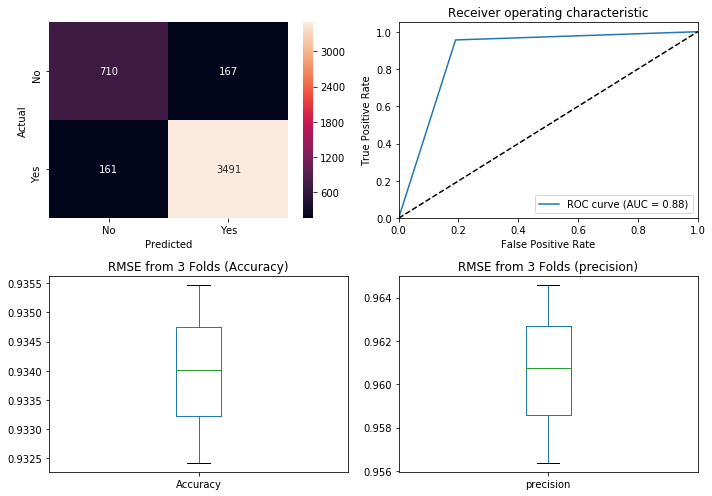

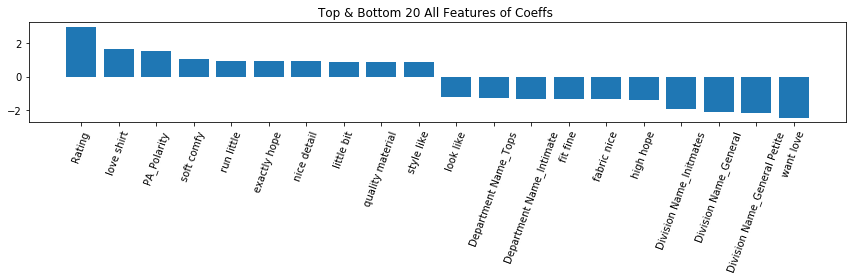

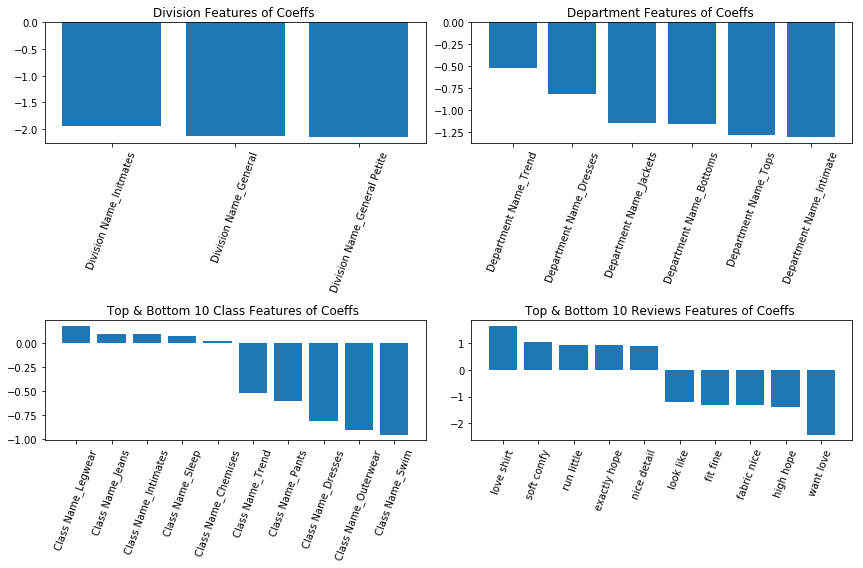

In [14]:
model=linear_model.LogisticRegression(n_jobs=1, solver='liblinear', C=1, penalty='l2', max_iter=1000)
param_grid={}#{'C':[0.01,1,100,1000]} 

model_experiment(model=model,param_grid=param_grid,df=df, InputFeaturecols=InputFeature,OutputFeaturecols=OutputFeature, nfolds=[2,3], ImpFtrShow=5, Reviewonly=False,FeatureReduction="None")

2019-08-27 18:11:44.735696 : Starting the model experiments
 
******* LogisticRegression *****
Number Input Features : 15448
Validation type : Cross Fold Validation
Cross Fold Split Size : 5
Important Feature Filter : 8
Feature Reduction : None
Show Category wise important Feature : False
***********************
 
Model Fit completed in 0.45 minutes 
 
********** Validation *************
Cross Validation Accuracy Scores [0.84588209 0.84231449 0.84386042 0.84430212 0.84253534]
Cross Validation Accuracy Mean Score 0.8437788921336937
Cross Validation Accuracy precision Score 0.84516771206637
Model Cross Validation completed in 2.94 minutes 
 


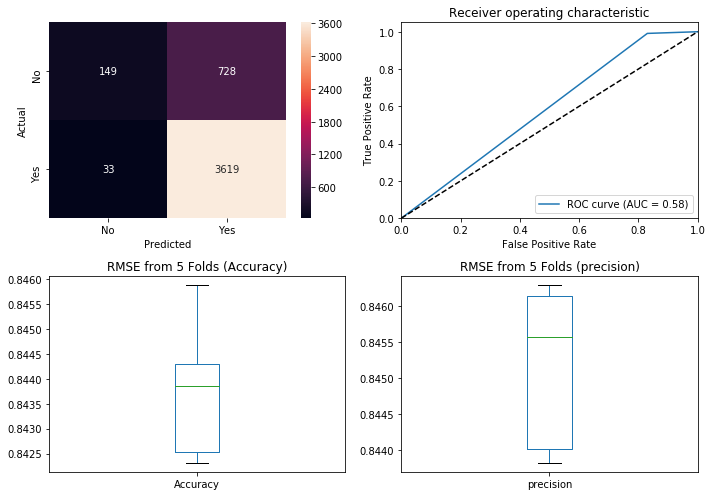

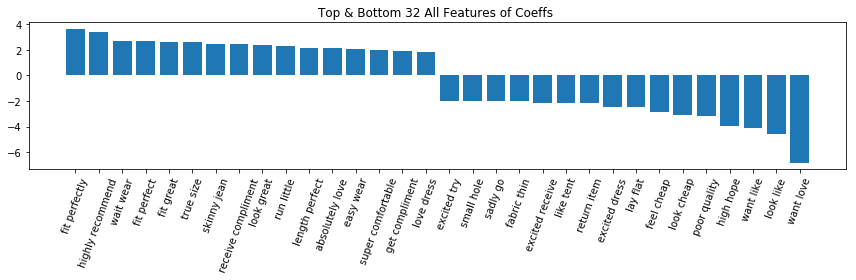

In [15]:
model=linear_model.LogisticRegression(n_jobs=1, solver='liblinear', C=1, penalty='l2', max_iter=1000)
param_grid={}#{'C':[0.01,1,100,1000]} 

model_experiment(model=model,param_grid=param_grid,df=df, InputFeaturecols=InputFeature[33:],OutputFeaturecols=OutputFeature, nfolds=[2,5], ImpFtrShow=8, Reviewonly=True,FeatureReduction="None")

2019-08-27 18:15:14.886432 : Starting the model experiments
 
******* MultinomialNB *****
Number Input Features : 15481
Grid Input : {'alpha': array([0.1  , 0.325, 0.55 , 0.775, 1.   ])}
Grid Search CV : 2
Validation type : Cross Fold Validation
Cross Fold Split Size : 3
Important Feature Filter : 5
Feature Reduction : None
Show Category wise important Feature : True
***********************
 


C:\Users\bsubramani\AppData\Local\Continuum\anaconda2\envs\snakes\lib\site-packages\ipykernel_launcher.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.3min finished


Best Parmater for model : {'alpha': 0.1}
Model GridSearch CV completed in 1.34 minutes 
 
********** Validation *************
Cross Validation Accuracy Scores [0.88816748 0.88883    0.88564993]
Cross Validation Accuracy Mean Score 0.8875491365222384
Cross Validation Accuracy precision Score 0.8949522874404593
Model Cross Validation completed in 0.8 minutes 
 


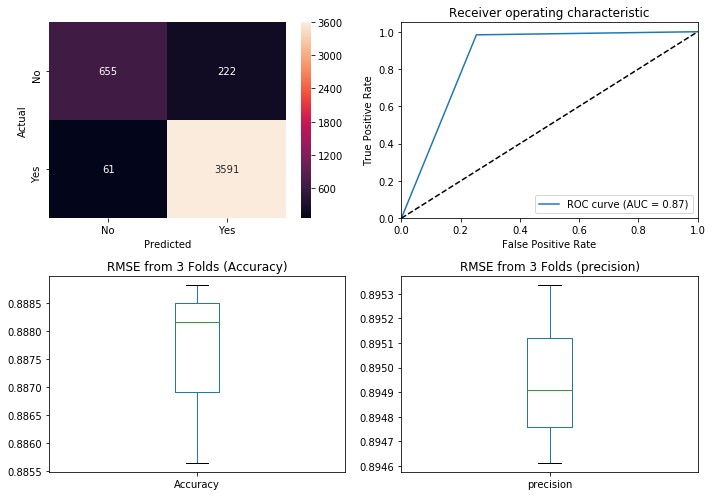

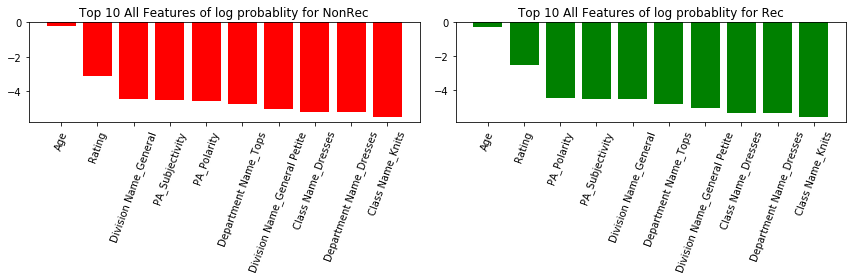

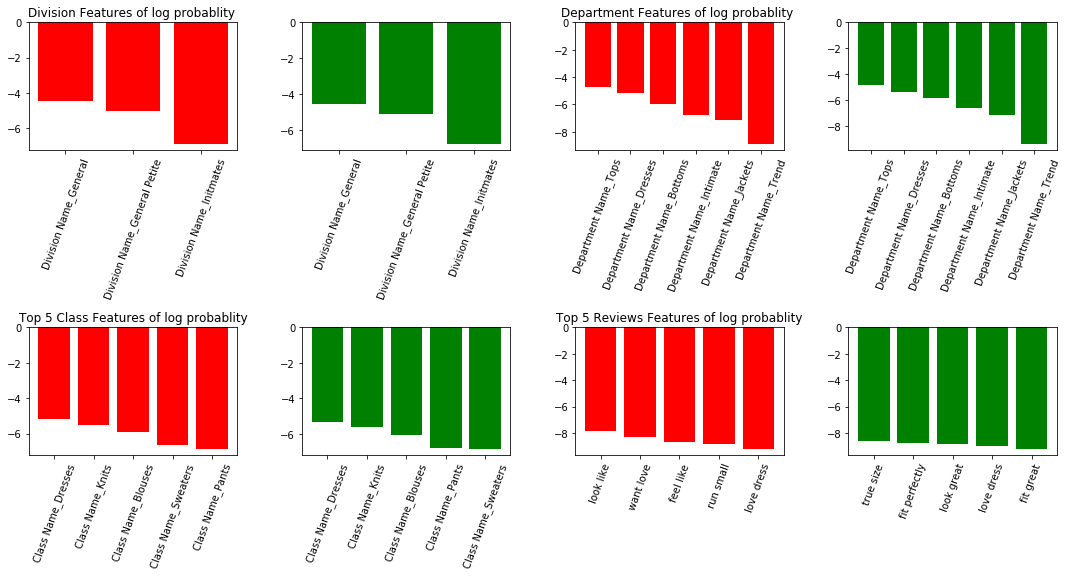

In [16]:
model = MultinomialNB(alpha=0.1)
param_grid={'alpha':np.linspace(0.1,1,5)} 

model_experiment(model=model,param_grid=param_grid,df=df, InputFeaturecols=InputFeature,OutputFeaturecols=OutputFeature, nfolds=[2,3], ImpFtrShow=5, Reviewonly=False,FeatureReduction="None")

2019-08-27 18:17:32.204665 : Starting the model experiments
 
******* MultinomialNB *****
Number Input Features : 15448
Grid Input : {'alpha': array([0.1  , 0.325, 0.55 , 0.775, 1.   ])}
Grid Search CV : 2
Validation type : Cross Fold Validation
Cross Fold Split Size : 5
Important Feature Filter : 5
Feature Reduction : None
Show Category wise important Feature : False
***********************
 
Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   42.9s finished


Best Parmater for model : {'alpha': 0.1}
Model GridSearch CV completed in 0.74 minutes 
 
********** Validation *************
Cross Validation Accuracy Scores [0.85935085 0.85887809 0.85733216 0.86174912 0.85424028]
Cross Validation Accuracy Mean Score 0.8583100993440779
Cross Validation Accuracy precision Score 0.8688794402595257
Model Cross Validation completed in 0.75 minutes 
 


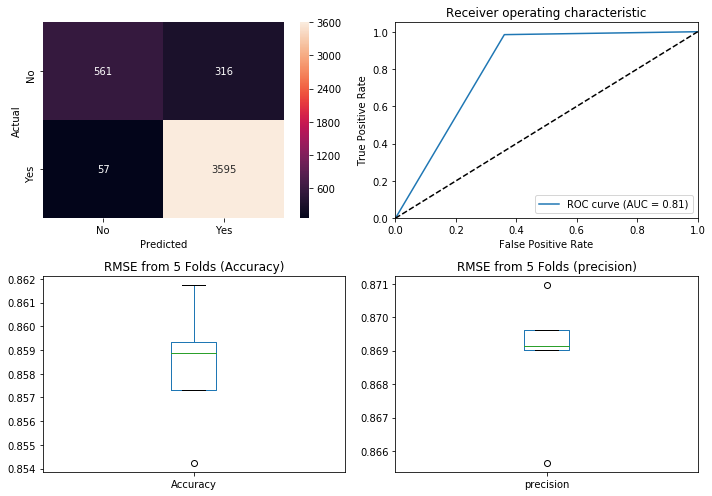

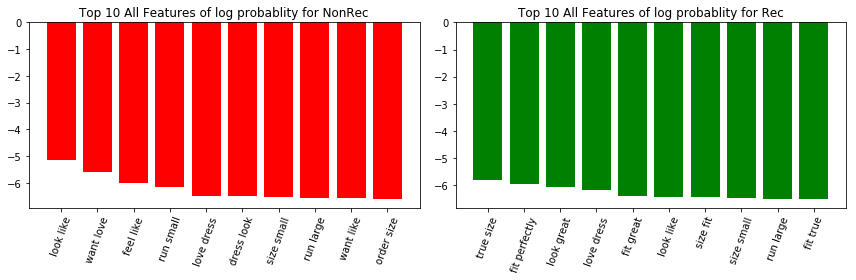

In [17]:
# model = MultinomialNB(alpha=0.1)
# param_grid={'alpha':np.linspace(0.1,1,5)} 
model_experiment(model=model,param_grid=param_grid,df=df, InputFeaturecols=InputFeature[33:],OutputFeaturecols=OutputFeature, nfolds=[2,5], ImpFtrShow=5, Reviewonly=True)

2019-08-27 18:19:09.483720 : Starting the model experiments
 
******* RandomForestClassifier *****
Number Input Features : 15481
Validation type : HoldOut
Important Feature Filter : 5
Feature Reduction : None
Show Category wise important Feature : True
***********************
 


C:\Users\bsubramani\AppData\Local\Continuum\anaconda2\envs\snakes\lib\site-packages\ipykernel_launcher.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Model Fit completed in 1.41 minutes 
 
********** Validation *************
Accuracy Score : 0.9315522190328991
precision  : 0.9712351945854484
recall  : 0.9430449069003286
AUC  : 0.9133696598355692
 


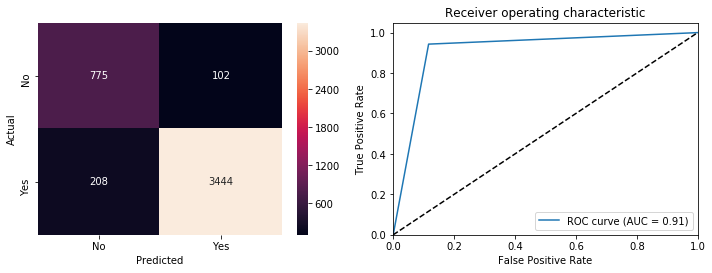

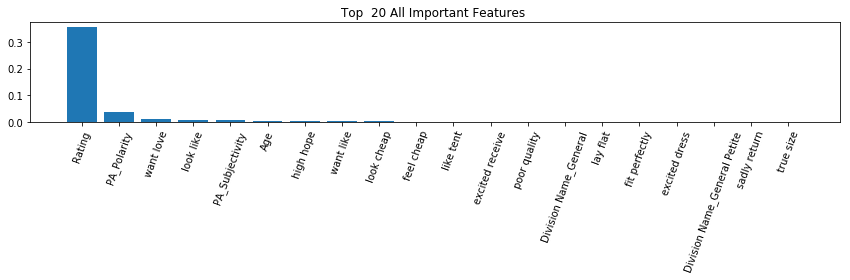

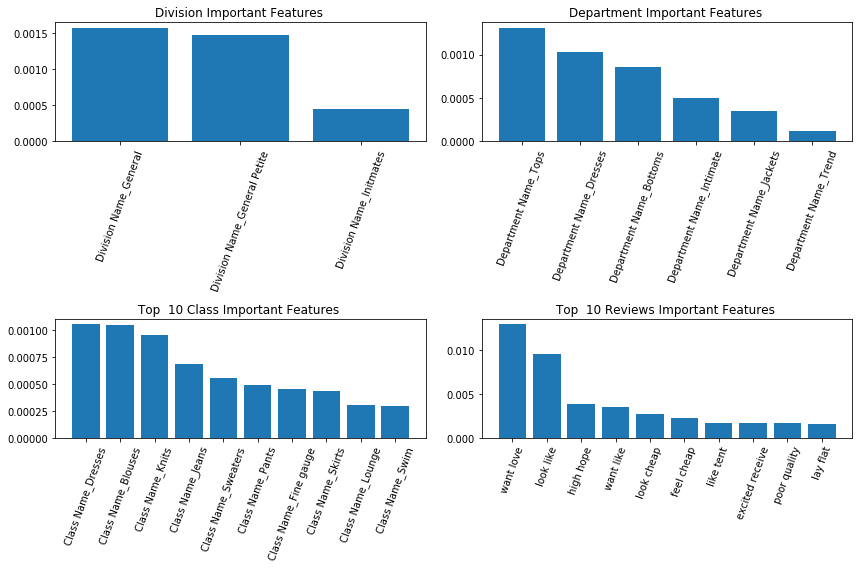

In [18]:
model = RandomForestClassifier(n_estimators=100,max_depth=None,n_jobs=-1)
param_grid={}

model_experiment(model=model,param_grid=param_grid,df=df, InputFeaturecols=InputFeature,OutputFeaturecols=OutputFeature, nfolds=[2,1], ImpFtrShow=5, Reviewonly=False)

2019-08-27 18:20:45.137494 : Starting the model experiments
 
******* RandomForestClassifier *****
Number Input Features : 15448
Validation type : HoldOut
Important Feature Filter : 10
Feature Reduction : None
Show Category wise important Feature : False
***********************
 
Model Fit completed in 4.58 minutes 
 
********** Validation *************
Accuracy Score : 0.8399205122543608
precision  : 0.8554772892883168
recall  : 0.9644030668127054
AUC  : 0.6429769039878805
 


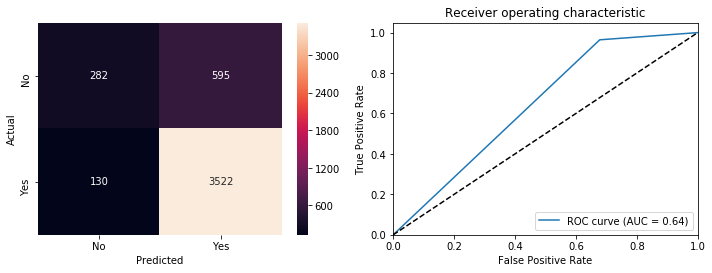

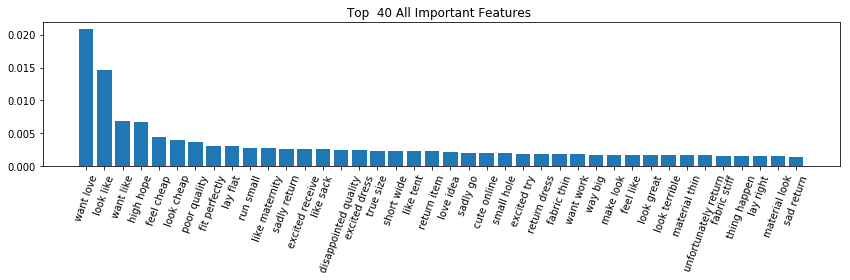

In [19]:
model_experiment(model=model,param_grid=param_grid,df=df, InputFeaturecols=InputFeature[33:],OutputFeaturecols=OutputFeature, nfolds=[2,1], ImpFtrShow=10, Reviewonly=True)

2019-08-27 18:25:28.676533 : Starting the model experiments
 
******* KNeighborsClassifier *****
Number Input Features : 15481
Validation type : HoldOut
Important Feature Filter : 5
Feature Reduction : None
Show Category wise important Feature : True
***********************
 


C:\Users\bsubramani\AppData\Local\Continuum\anaconda2\envs\snakes\lib\site-packages\ipykernel_launcher.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Model Fit completed in 1.05 minutes 
 
********** Validation *************
Accuracy Score : 0.9178626628394789
precision  : 0.9427645788336934
recall  : 0.9561883899233297
AUC  : 0.8572276043117218
 


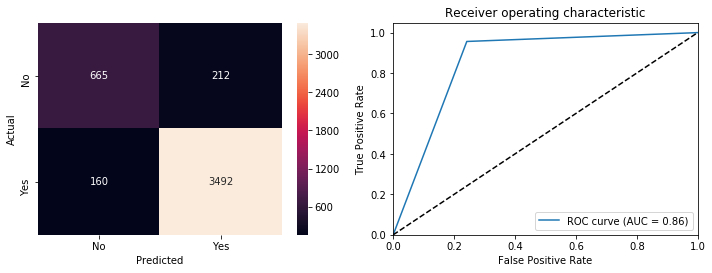

In [20]:
model = KNeighborsClassifier(n_neighbors=3)
param_grid={}#{'n_neighbors':[3,6,12]} 
model_experiment(model=model,param_grid=param_grid,df=df, InputFeaturecols=InputFeature,OutputFeaturecols=OutputFeature, nfolds=[2,1], ImpFtrShow=5, Reviewonly=False)

2019-08-27 18:29:24.370807 : Starting the model experiments
 
******* KNeighborsClassifier *****
Number Input Features : 15448
Validation type : HoldOut
Important Feature Filter : 10
Feature Reduction : None
Show Category wise important Feature : False
***********************
 
Model Fit completed in 1.02 minutes 
 
********** Validation *************
Accuracy Score : 0.6941929785824685
precision  : 0.8126896551724138
recall  : 0.8066812705366923
AUC  : 0.5162254699319722
 


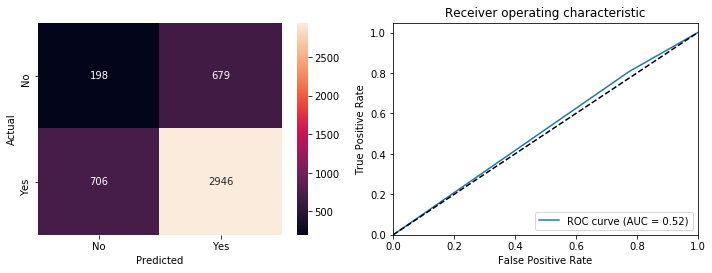

In [21]:
model_experiment(model=model,param_grid=param_grid,df=df, InputFeaturecols=InputFeature[33:],OutputFeaturecols=OutputFeature, nfolds=[2,1], ImpFtrShow=10, Reviewonly=True)

2019-08-27 20:19:25.210166 : Starting the model experiments
 
******* SVC *****
Number Input Features : 15481
Validation type : HoldOut
Important Feature Filter : 10
Feature Reduction : None
Show Category wise important Feature : True
***********************
 


C:\Users\bsubramani\AppData\Local\Continuum\anaconda2\envs\snakes\lib\site-packages\ipykernel_launcher.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Model Fit completed in 119.81 minutes 
 
********** Validation *************
Accuracy Score : 0.925590638109958
precision  : 0.9623430962343096
recall  : 0.9446878422782037
AUC  : 0.8953769884139022
 


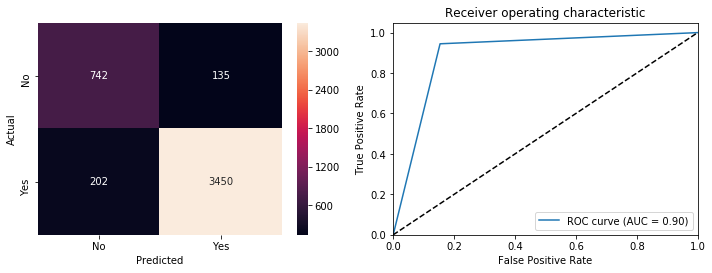

In [23]:
model=SVC(C=10,  gamma=0.1)
param_grid={}

model_experiment(model=model,param_grid=param_grid,df=df, InputFeaturecols=InputFeature,OutputFeaturecols=OutputFeature, nfolds=[2,0], ImpFtrShow=10, Reviewonly=False)

2019-08-27 22:29:08.959319 : Starting the model experiments
 
******* SVC *****
Number Input Features : 15448
Validation type : HoldOut
Important Feature Filter : 10
Feature Reduction : None
Show Category wise important Feature : False
***********************
 
Model Fit completed in 171.8 minutes 
 
********** Validation *************
Accuracy Score : 0.8467652903510708
precision  : 0.8704909819639278
recall  : 0.9515334063526835
AUC  : 0.6810118571102072
 


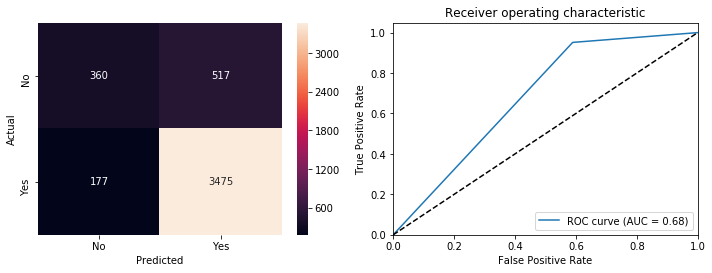

In [24]:
model_experiment(model=model,param_grid=param_grid,df=df, InputFeaturecols=InputFeature[33:],OutputFeaturecols=OutputFeature, nfolds=[2,0], ImpFtrShow=10, Reviewonly=True)